# Preliminary exploration notebook

This notebook contains the following:
* Data loading and brief visualization
* tbd

In [ ]:
# for work in colab environment
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os # work with system
import cv2 # work with images
import numpy as np # arrays and numerical analysis
import matplotlib.pyplot as plt # for data plots
import pandas as pd

import sklearn.linear_model # linear models
from sklearn.model_selection import train_test_split # data splitting
from sklearn import metrics # model evaluation
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import random # for random sampling

from google.colab.patches import cv2_imshow # to display image in colab

### set working directory in data folder - assumes unzipped data lives in such a directory
os.chdir("drive/Shareddrives/STAT654_Project/streetsign_data")

In [ ]:
os.getcwd()

'/content/drive/Shareddrives/STAT654_Project/streetsign_data'

In [ ]:
counter = 0 # if desired to break loop

# labels and filenames should match since they are appended in order
filenames = []
labels = []
labels_sub = []
n_mph = n_turn = n_road = 0

# walk through all directories and files in current working directory
for root, dir, files in os.walk(os.getcwd()):
  print(root)

  for fig in files:
      # if png file, then keep filename
    if ".png" in fig:
      filenames.append(os.path.join(root, fig))

      labels_sub.append(root.split('/')[-1])

print(len(filenames))

/content/drive/Shareddrives/STAT654_Project/streetsign_data
/content/drive/Shareddrives/STAT654_Project/streetsign_data/20mph
/content/drive/Shareddrives/STAT654_Project/streetsign_data/30mph
/content/drive/Shareddrives/STAT654_Project/streetsign_data/10mph
/content/drive/Shareddrives/STAT654_Project/streetsign_data/40mph
/content/drive/Shareddrives/STAT654_Project/streetsign_data/road_narrows_on_both_sides
/content/drive/Shareddrives/STAT654_Project/streetsign_data/road_narrows_on_right
/content/drive/Shareddrives/STAT654_Project/streetsign_data/road_narrows_on_left
/content/drive/Shareddrives/STAT654_Project/streetsign_data/turn_right
/content/drive/Shareddrives/STAT654_Project/streetsign_data/turn_left_ahead
/content/drive/Shareddrives/STAT654_Project/streetsign_data/turn_left
/content/drive/Shareddrives/STAT654_Project/streetsign_data/no_entry
/content/drive/Shareddrives/STAT654_Project/streetsign_data/no_through_road
/content/drive/Shareddrives/STAT654_Project/streetsign_data/keep

In [ ]:
unique_labels = list(set(labels_sub))
labels_sub_dict = dict(zip(unique_labels, list(range(len(unique_labels)))))
labels_sub_dict

{'road_works': 0,
 'crossroads': 1,
 'road_humps': 2,
 'no_left_turn': 3,
 'give_way': 4,
 'zebra_crossing': 5,
 'road_narrows_on_right': 6,
 'no_through_road': 7,
 'road_narrows_on_left': 8,
 'turn_left_ahead': 9,
 'traffic_has_priority': 10,
 'no_right_turn': 11,
 'give_way_to_oncoming': 12,
 'keep_right': 13,
 'turn_right': 14,
 'no_motor_vehicles': 15,
 '30mph': 16,
 'road_narrows_on_both_sides': 17,
 'frail': 18,
 '10mph': 19,
 'turn_left': 20,
 '40mph': 21,
 'school_crossing': 22,
 'one_way_traffic': 23,
 'cycle_route_ahead': 24,
 'keep_left': 25,
 'two_way_traffic': 26,
 'traffic_signals': 27,
 'no_entry': 28,
 '20mph': 29,
 'mini_roundabout': 30}

In [ ]:
labels_sub = [labels_sub_dict[x] for x in labels_sub]

filenames_arr = np.array(filenames)
labels_arr = np.array(labels)
labels_sub_arr = np.array(labels_sub)

In [ ]:
tmp_dict = {value: key for key, value in labels_sub_dict.items()}

tmp = pd.DataFrame({'cat': labels_sub})
tmp['label'] = tmp['cat'].map(tmp_dict)
tmp.value_counts().reset_index()

,cat,label,count
0,29,20mph,4617
1,4,give_way,4082
2,19,10mph,3639
3,28,no_entry,3209
4,16,30mph,2668
5,26,two_way_traffic,2623
6,11,no_right_turn,2418
7,2,road_humps,2372
8,20,turn_left,2320
9,5,zebra_crossing,2314


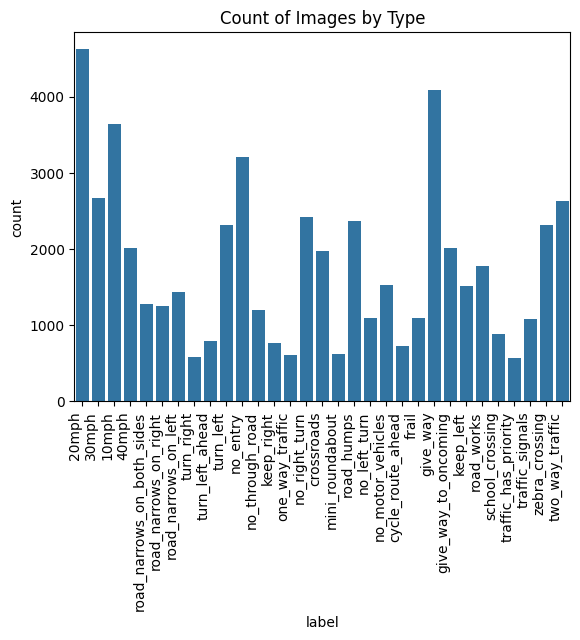

In [ ]:
# vizualize data availability by category

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x = 'label', data = tmp)
plt.xticks(rotation=90, ha='right')
plt.title('Count of Images by Type')
plt.show()

# functions

In [ ]:
# labels2 is the subcat labels, use labels for resampling based on 3 overarching cats
def resample_classes(files, labels, seed):

  '''
  files and labels should both be np arrays
  '''

  # set seed for reproducibility (and possibly error computation)
  random.seed(seed)
  # get number of minimum class
  # n_minority = np.min([n_mph, n_turn, n_mph])
  n_minority = 576 # minumum class across all 31 categories

  # downsample to minimum across categories
  out_index = np.empty(n_minority*31)
  for i in range(31):
    if i == 0:
      out_index = np.array(random.sample(list(np.where(labels == i)[0]), n_minority))
    else:
      out_index = np.concatenate((out_index, np.array(random.sample(list(np.where(labels == i)[0]), n_minority))))

  # subset to resampled data - classes now balanced
  filenames_resampled = files[out_index]
  labels_resampled = labels[out_index]

  print(f'total samples: {out_index.shape[0]}')
  for i in range(31):
    print(f'samples for {i}: {labels_resampled[labels_resampled == i].shape[0]}')

  return filenames_resampled, labels_resampled

In [ ]:
def split_data(files, labels, seed = 27, train = 0.8, test = 0.15):

  '''
  files and labels should both be np arrays
  '''

  # split data: train is 1-test_size and test is test_size*leftover
  # must stratify to ensure roughly equal splits in train, val, test
  # train and test specified, val is 1 - (train + test)
  x_train, x_test, y_train, y_test = train_test_split(
      files, labels, test_size = 1-train, stratify = labels, shuffle = True, random_state = seed)
  x_val, x_test, y_val, y_test = train_test_split(
      x_test, y_test, test_size = test/(1-train), stratify = y_test, shuffle = True, random_state = seed)

  print(f'train: {x_train.shape[0]} ({x_train.shape[0]/labels.shape[0]*100:.2f}%)')
  print(f'val: {x_val.shape[0]} ({x_val.shape[0]/labels.shape[0]*100:.2f}%)')
  print(f'test: {x_test.shape[0]} ({x_test.shape[0]/labels.shape[0]*100:.2f}%)')

  return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
class data_generator(keras.utils.Sequence) :

  def __init__(self, image_filenames, labels, batch_size, log) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.log = log

  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)

  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

    # read in and process image (different resizing for logistic regression to reduce trainable parameters)
    if self.log:
      x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (100, 60), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]
    else:
      x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (256, 256), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]

    x_arr = np.array(x_list)
    x_arr_reshaped = x_arr.reshape([x_arr.shape[0], x_arr.shape[1], x_arr.shape[2], 1])

    y_arr = np.array(batch_y)
    y_arr_reshaped = y_arr.reshape([x_arr_reshaped.shape[0], 1])

    return x_arr_reshaped, y_arr_reshaped

In [ ]:
def create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = 32, log = False):

  train_generator = data_generator(x_train, y_train, batch_size, log)
  validation_generator = data_generator(x_val, y_val, batch_size, log)
  test_generator = data_generator(x_test, y_test, batch_size, log)

  return train_generator, validation_generator, test_generator


In [ ]:
def count_split(data): # much better would be to count 0 and 1 in y_*

  data = list(data)
  snake = [x for x in data if "Snake_Images" in x]
  empty = [x for x in data if "Empty" in x]

  print(f'total: {len(data)}')
  print(f'snake: {len(snake)} ({len(snake)/len(data)*100:.2f}%)')
  print(f'empty: {len(empty)} ({len(empty)/len(data)*100:.2f}%)')

## CNN - basic

In [ ]:
seed = 1
batch_size = 32

filenames_resampled, labels_resampled = resample_classes(filenames_arr, labels_sub_arr, seed)
filenames_resampled, labels_resampled = filenames_arr, labels_sub_arr
x_train, y_train, x_val, y_val, x_test, y_test = split_data(filenames_resampled, labels_resampled, train = 0.7, test = 0.2)


total samples: 17856
samples for 0: 576
samples for 1: 576
samples for 2: 576
samples for 3: 576
samples for 4: 576
samples for 5: 576
samples for 6: 576
samples for 7: 576
samples for 8: 576
samples for 9: 576
samples for 10: 576
samples for 11: 576
samples for 12: 576
samples for 13: 576
samples for 14: 576
samples for 15: 576
samples for 16: 576
samples for 17: 576
samples for 18: 576
samples for 19: 576
samples for 20: 576
samples for 21: 576
samples for 22: 576
samples for 23: 576
samples for 24: 576
samples for 25: 576
samples for 26: 576
samples for 27: 576
samples for 28: 576
samples for 29: 576
samples for 30: 576
train: 38569 (70.00%)
val: 5510 (10.00%)
test: 11021 (20.00%)


In [ ]:
# create data generators
train_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = batch_size, log = False)

In [ ]:
# create model
def build_model():

    model = models.Sequential()
    model.add(layers.Rescaling(1./255, input_shape = (256, 256, 1)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(31, activation = 'softmax'))

    # compile model with desired features
    model.compile(
        optimizer = "adam", loss = "sparse_categorical_crossentropy",
        metrics=['accuracy']
    )

    return model

In [ ]:
# build the model
cnn_model = build_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# view model architecture
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 31)                  │           3,999 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,400,223 (28.23 MB)

 Trainable params: 7,400,223 (28.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
refit = False
model_filename = '../cnn_scratch_subcats_all_resampled.keras'
mapping_filename = '../cnn_scratch_subcats_all_mapping.csv'

if refit:

  mapping_filename_df = pd.DataFrame({'name': unique_labels, 'label': list(range(len(unique_labels)))})
  mapping_filename_df.to_csv(mapping_filename)

  cnn_fit = cnn_model.fit(
      train_generator,
      steps_per_epoch = (int(x_train.shape[0] // batch_size)//10 + 1),
      # steps_per_epoch = 10,
      epochs = 10,
      verbose = 1,
      validation_data = validation_generator,
      validation_steps = int(x_val.shape[0] // batch_size)//10 + 1
      # validation_steps = 3
  )

  try:
    cnn_model.save(model_filename)
  except Exception as e:
    print(e)
else:
  cnn_model = tf.keras.models.load_model(model_filename)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 972s 8s/step - accuracy: 0.4942 - loss: 1.9834 - val_accuracy: 0.9497 - val_loss: 0.2137
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 878s 7s/step - accuracy: 0.9682 - loss: 0.1201 - val_accuracy: 0.9826 - val_loss: 0.0758
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 806s 7s/step - accuracy: 0.9855 - loss: 0.0771 - val_accuracy: 0.9878 - val_loss: 0.0472
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 862s 7s/step - accuracy: 0.9786 - loss: 0.1118 - val_accuracy: 0.9931 - val_loss: 0.0367
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 802s 7s/step - accuracy: 0.9884 - loss: 0.0491 - val_accuracy: 0.9965 - val_loss: 0.0154
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 801s 7s/step - accuracy: 0.9892 - loss: 0.0497 - val_accuracy: 0.9931 - val_loss: 0.0260
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 862s 7s/step - accuracy: 0.9928 - loss: 0.0282 - val_accuracy: 1.0000 - val_loss: 0.0108
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 787s 7s/step - accuracy: 0.9908 - loss: 0.0290 - val_accu

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


121/121 ━━━━━━━━━━━━━━━━━━━━ 862s 7s/step - accuracy: 0.9967 - loss: 0.0132 - val_accuracy: 0.9983 - val_loss: 0.0044


In [ ]:
model_predict = cnn_model.predict(
    test_generator,
)

345/345 ━━━━━━━━━━━━━━━━━━━━ 2345s 7s/step


In [ ]:
model_predict

array([[3.54409408e-08, 2.54107100e-08, 2.04581934e-08, ...,
        3.21439393e-06, 9.47190060e-09, 1.07542284e-04],
       [7.64802392e-13, 1.47358459e-09, 1.35335831e-11, ...,
        3.32854810e-13, 2.84752598e-16, 1.66672685e-08],
       [1.96284964e-13, 3.35423955e-09, 3.23381933e-15, ...,
        9.68869828e-14, 1.95389003e-08, 4.15041068e-09],
       ...,
       [1.43915587e-12, 3.33883413e-14, 5.86447418e-11, ...,
        1.17459764e-09, 8.69923654e-13, 4.63223091e-15],
       [2.92737043e-22, 5.88681126e-19, 2.72854960e-20, ...,
        2.01735150e-16, 5.02045745e-16, 1.15122674e-13],
       [2.31218582e-12, 1.35349293e-11, 1.31729827e-08, ...,
        3.29570270e-07, 2.00378386e-12, 8.71962990e-15]], dtype=float32)

In [ ]:
labels_predict = np.argmax(model_predict, axis=1)
labels_predict.shape

set(list(labels_predict))

{np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16),
 np.int64(17),
 np.int64(18),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(22),
 np.int64(23),
 np.int64(24),
 np.int64(25),
 np.int64(26),
 np.int64(27),
 np.int64(28),
 np.int64(29),
 np.int64(30)}

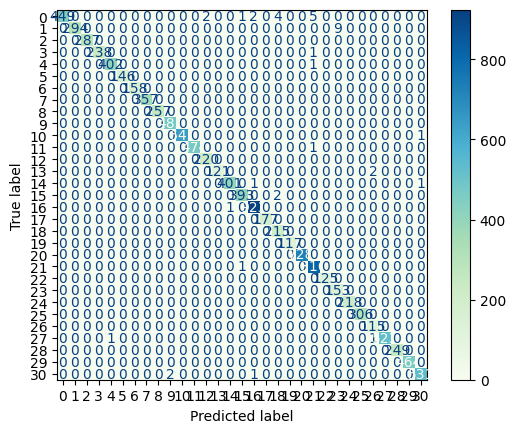

In [ ]:
# plot confusion matrix
plt.figure(figsize = (12,12))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, labels_predict, cmap = "GnBu")

In [ ]:
# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, labels_predict)
print("accuracy: " + str(accuracy))

accuracy: 0.996370565284457


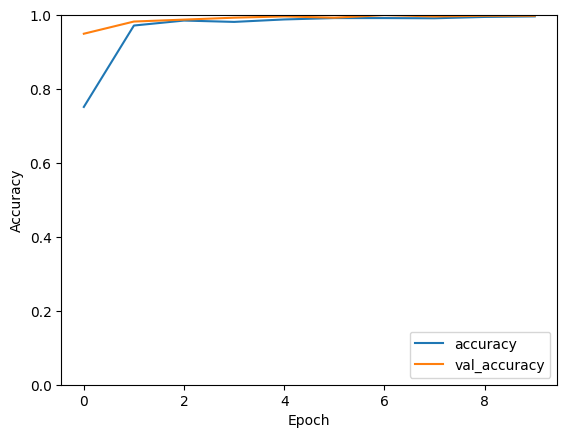

In [ ]:
# plot accuracy across epochs
plt.plot(cnn_fit.history['accuracy'], label='accuracy')
plt.plot(cnn_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')